In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [24]:
import datetime as dt
from utils import get_past_date
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [22]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [11]:
# Inspect database
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [12]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

2010-01-01
2017-08-23


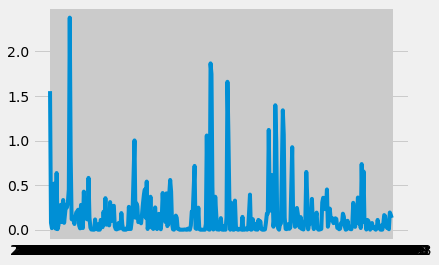

In [38]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
earliest_date = session.query(Measurement.date).order_by(Measurement.date).first()
print(earliest_date[0])

latest_date = session.query(Measurement.date).order_by(desc(Measurement.date)).first()
print(latest_date[0])

one_year_delta = dt.datetime.strptime(latest_date[0], '%Y-%m-%d') - relativedelta(years=1)

# Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, func.avg(Measurement.prcp)).filter(Measurement.date > one_year_delta).group_by(Measurement.date).all()
# print(query)

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(query, columns=['date', 'precipitation'])
df.head()

# Sort the dataframe by date
df.sort_values(by=['date'], inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots()
ax.plot(df['date'], df['precipitation'])


![precipitation](Images/precipitation.png)

In [39]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


![describe](Images/describe.png)

In [42]:
# Design a query to show how many stations are available in this dataset?
query = session.query(Station).distinct(Station.name).group_by(Station.name).count()
print(query)

9


In [59]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
query = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

for q in query:
    print(*q)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [70]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
query = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station=='USC00519281').first()

print(query)


(54.0, 85.0, 71.66378066378067)


In [75]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.tobs).order_by(func.count(Measurement.tobs).desc()).first()
print(query)



('USC00519397', 1752)


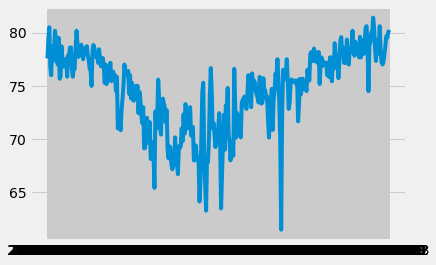

In [77]:
query = session.query(Measurement.date, func.avg(Measurement.tobs)).filter(Measurement.date > one_year_delta).group_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(query, columns=['date', 'temperature'])
df.head()

# Sort the dataframe by date
df.sort_values(by=['date'], inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots()
ax.plot(df['date'], df['temperature'])

![precipitation](Images/station-histogram.png)

In [78]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [82]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temp = calc_temps('2012-02-28', '2012-03-05')
trip_temp

[(62.0, 69.57142857142857, 74.0)]

Text(0, 0.5, 'Temp(F)')

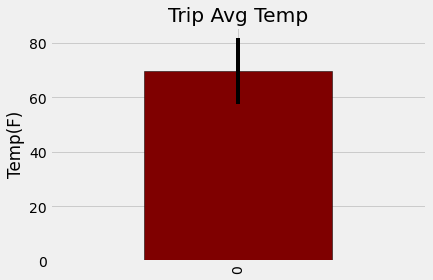

In [94]:
# fig, ax = plt.subplots()
# ax.plot(, df['temperature'])
trip_df = pd.DataFrame(trip_temp, columns=['Tmin', 'Tave', 'Tmax'])
trip_df['error'] = trip_df['Tmax'] - trip_df['Tmin']

meansum = trip_df['Tave']
stdsum = trip_df['error']
fig, ax = plt.subplots()
ax = meansum.plot(kind='bar', yerr=stdsum,  colormap='OrRd_r',edgecolor='black',grid=True)
ax.set_title('Trip Avg Temp')
ax.set_ylabel('Temp(F)')


<IPython.core.display.Javascript object>


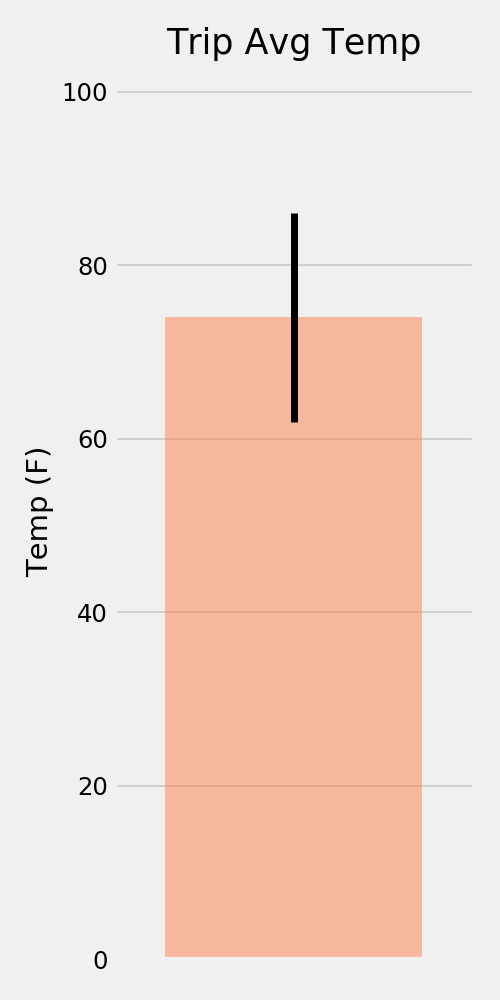

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [97]:
start_date = '2012-02-28' 
end_date = '2012-03-05'
query = session.query(Station.station, Station.name, Station.longitude, Station.latitude, func.sum(Measurement.prcp)).join(Measurement, Station.station == Measurement.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Station.station).all()
print(query)

[('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', -157.9992, 21.3152, 0.76), ('USC00513117', 'KANEOHE 838.1, HI US', -157.8015, 21.4234, 5.79), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', -157.8374, 21.5213, 0.03), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', -157.8025, 21.3331, 10.32), ('USC00517948', 'PEARL CITY, HI US', -157.9751, 21.3934, 0.0), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', -158.0111, 21.4992, 3.8400000000000003), ('USC00519281', 'WAIHEE 837.5, HI US', -157.84888999999998, 21.45167, 11.08), ('USC00519397', 'WAIKIKI 717.2, HI US', -157.8168, 21.2716, 1.1800000000000002), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', -157.71139, 21.33556, 2.92)]


In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [115]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [121]:
def date_range_to_month_day(start_date, end_date):
    dates = list()
    dates_full = list()
    date1 = start_date
    date2 = end_date
    start = dt.datetime.strptime(date1, '%Y-%m-%d')
    end = dt.datetime.strptime(date2, '%Y-%m-%d')
    step = dt.timedelta(days=1)
    while start <= end:
        dates.append(dt.datetime.strptime(str(start.date()), '%Y-%m-%d').strftime('%m-%d'))
        dates_full.append(dt.datetime.strptime(str(start.date()), '%Y-%m-%d'))
        start += step
    return dates, dates_full


In [122]:
normals = list()
start_date = '2012-02-28' 
end_date = '2012-03-05'
dates = date_range_to_month_day(start_date, end_date)

for d in dates[0]:
    normals.append(*daily_normals(d))

print(normals)



[(65.0, 70.65517241379311, 80.0), (67.0, 71.73333333333333, 79.0), (64.0, 70.0327868852459, 76.0), (61.0, 70.36666666666666, 78.0), (60.0, 70.06896551724138, 78.0), (57.0, 69.27272727272727, 77.0), (60.0, 67.89090909090909, 76.0)]


In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [125]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_dates_df = pd.DataFrame(normals, columns=['tmin', 'tAvg', 'tmax'], index=dates[1])
trip_dates_df.reset_index()

,index,tmin,tAvg,tmax
0,2012-02-28,65.0,70.655172,80.0
1,2012-02-29,67.0,71.733333,79.0
2,2012-03-01,64.0,70.032787,76.0
3,2012-03-02,61.0,70.366667,78.0
4,2012-03-03,60.0,70.068966,78.0
5,2012-03-04,57.0,69.272727,77.0
6,2012-03-05,60.0,67.890909,76.0


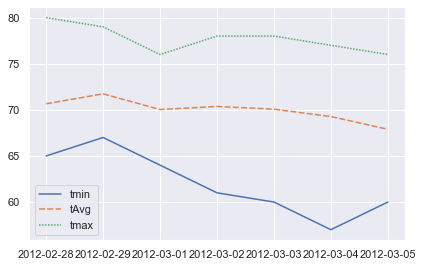

In [127]:
import seaborn as sns; sns.set()
ax = sns.lineplot(data=trip_dates_df)

<IPython.core.display.Javascript object>


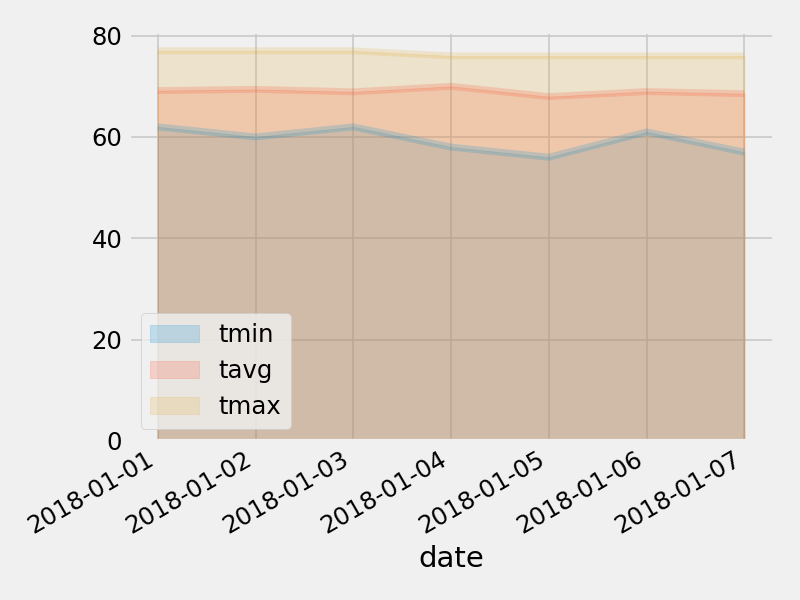

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
